In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [2]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
import jax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots import bundles
import random
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from dataloader import *
from model import *
from utilities import *
from recalibration import *
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-05-25 17:16:17.145304: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [4]:
train_list = [[2361, 7719, 9019, 2335, 7951]]
cal_list = [[5746, 8565, 8156, 8386, 9160]]
test_list = [[4373, 7901, 3456, 3538, 2818]]

In [5]:
dict_bs_lr = {'air': (2048, 0.0001), 'refrigerator': (1024, 0.0001), 'furnace': (
    2048, 0.00001), 'dishwasher': (4096, 0.0001), 'clotheswasher': (2048, 0.0001)}
appliance = 'furnace'

In [6]:
train_houses = train_list[0]
test_houses = test_list[0]
cal_houses = cal_list[0]
train = data_aggregated[data_aggregated["dataid"].isin(train_houses)]
test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]
cal = data_aggregated[data_aggregated["dataid"].isin(cal_houses)]

In [7]:
n = 99
x_train, y_train = dataloader(
    appliance, train, "2018-03-01 00:00:00-06", "2018-03-15 23:59:00-06", n)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)
x_train = jnp.array(x_train).reshape(x_train.shape[0], n, 1)
y_train = jnp.array(y_train)

In [8]:
model = seq2point()
params = model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False,
                     batch_size=dict_bs_lr[f'{appliance}'][0], learning_rate=dict_bs_lr[f'{appliance}'][1], epochs=30)

Training Progress:   0%|          | 0/1110 [00:00<?, ?epoch/s]

{'params': {'params': {'Conv_0': {'kernel': Array([[[ 5.91041028e-01,  2.66893446e-01,  5.20375073e-01,
         -1.75426587e-01,  1.11543357e-01, -2.95189977e-01,
         -2.72156477e-01,  2.72307634e-01, -1.28517941e-01,
          3.87078971e-02,  1.44327298e-01,  5.17742075e-02,
         -5.02306759e-01,  3.10272694e-01, -2.35921852e-02,
          1.30479887e-01, -2.83341631e-02, -1.35695711e-01,
         -9.30810422e-02, -2.10507944e-01, -2.45641500e-01,
         -3.71715635e-01,  2.91475654e-01, -2.18518868e-01,
          3.18842798e-01, -6.16426095e-02,  6.61751553e-02,
          2.19490260e-01, -2.11068824e-01, -3.74614328e-01]],

       [[ 5.92248619e-01,  2.79695183e-01, -6.32752538e-01,
         -1.20921433e-01,  9.02841911e-02,  2.39176571e-01,
          1.21174596e-01, -6.44544423e-01, -1.06295124e-01,
         -2.66009688e-01, -2.88003922e-01, -4.95881617e-01,
          3.05347562e-01,  6.35713160e-01, -2.05620885e-01,
          2.93978393e-01, -6.76439226e-01, -4.0735080

Training Progress: 100%|██████████| 1110/1110 [00:10<00:00, 105.66epoch/s]


In [9]:
n_stacks = 3


def fn(x, i): return model.apply(params, x, False,
                                 rngs={"dropout": jax.random.PRNGKey(i)})

In [10]:
x_test, y_test = dataloader(
    appliance, test, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_test = scaler_x.transform(x_test)
x_test = jnp.array(x_test).reshape(x_test.shape[0], n, 1)
y_test = jnp.array(y_test)

In [11]:
x_cal, y_cal = dataloader(
    appliance, cal, "2018-05-01 00:00:00-06", "2018-05-10 23:59:00-06", n)
x_cal = scaler_x.transform(x_cal)
x_cal = jnp.array(x_cal).reshape(x_cal.shape[0], n, 1)
y_cal = jnp.array(y_cal)

In [12]:
y_stacks_test = jax.vmap(jax.jit(fn), in_axes=(
    None, 0))(x_test, jnp.arange(n_stacks))

mc_test_mean = y_stacks_test.mean(axis=0)
mc_test_sigma = y_stacks_test.std(axis=0)
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)
print(
    f"RMSE : {rmse(y_test, mc_test_mean):.4f}, MAE : {mae(y_test, mc_test_mean):.4f}")

RMSE : 371.3113, MAE : 161.5509


In [13]:
y_stacks_train = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_train, jnp.arange(n_stacks))
mc_train_mean = y_stacks_train.mean(axis=0)
mc_train_sigma = y_stacks_train.std(axis=0)

mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)
y_train_scaled = scaler_y.inverse_transform(y_train)
print(
    f"RMSE : {rmse(y_train, mc_train_mean):.4f}, MAE : {mae(y_train, mc_train_mean):.4f}")

RMSE : 324.1058, MAE : 88.7345


In [14]:
y_stacks_cal = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_cal, jnp.arange(n_stacks))
mc_cal_mean = y_stacks_cal.mean(axis=0)
mc_cal_sigma = y_stacks_cal.std(axis=0)
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)
y_true_cal = scaler_y.inverse_transform(y_cal)
print(
    f"RMSE : {rmse(y_cal, mc_cal_mean):.4f}, MAE : {mae(y_cal, mc_cal_mean):.4f}")

RMSE : 709.0115, MAE : 309.6483


## After Calibration

Isotonic Regression

In [15]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [16]:
series_train = find_p_hat(y_train, mc_train_mean, mc_train_sigma)
series_test = find_p_hat(y_test, mc_test_mean, mc_test_sigma)
series_cal = find_p_hat(y_cal, mc_cal_mean, mc_cal_sigma)

In [17]:
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression(out_of_bounds='clip')

In [18]:
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [19]:
new_p_hat_train = find_new_p_hat(
    y_train, new_p, mc_train_mean, mc_train_sigma)
new_p_hat_cal = find_new_p_hat(y_cal, new_p, mc_cal_mean, mc_cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, mc_test_mean, mc_test_sigma)

In [20]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

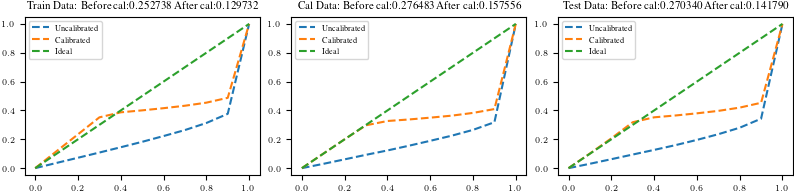

In [21]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal.pdf')